# Information Processing for Medical Imaging 2018/2019
## Registration workshop 2
### 24th January 2019

### Python version

### PART 1: Similarity Measures

[Open in Colab](https://colab.research.google.com/github/meganzoe/ipmi-registration/blob/master/workshop_2/registration_workshop_2.ipynb)

Uncomment the lines below to clone the code into the vritual Colab workspace. 

In [ ]:
#!git clone https://github.com/meganzoe/ipmi-registration
#import os
#os.chdir('ipmi-registration/workshop_2')

Load the 2D images stored in `ct_slice_int8.png`,  `ct_slice_int16.png`, `mr_slice_int16.png`. 

The images are stored as 8 and 16 bit unsigned integers, as the names suggest. Remember to convert them to doubles/floats to avoid processing errors, and to re-orientate them into ‘standard orientation’ as before.

Display the images using the `dispImage` function from last week. You should notice that the two CT images appear exactly the same, but if you examine the actual values in the images you will see that the images use different intensity ranges. In the 16 bit version, the intensity values correspond to Hounsfield Units (or rather Hounsfield Units + 1000, since air has a value of -1000, but the image cannot contain negative values as it is stored as unsigned integers), but in the 8 bit image the values have been scaled as the image can only contain values from 0 to 255.

Using the function you wrote last week, write code below that will transform each of the images by theta = -90:90 degrees about the point 10,10. Remember to avoid multiple re-samplings by always resampling the original images, and to use pull interpolation (so the image will appear to rotate clockwise). As the image is being rotated about a point near the bottom left of the image it should appear to move in from the left hand side of the image and then disappear off the bottom of the image (if you are unsure if your images are being transformed correctly ask one of the helpers).

For each value of theta use the provided `calcSSD` function within `utils.py` to calculate the SSD between:
1.	The original 16 bit CT and the rotated 16 bit CT
2.	The original 16 bit CT and the rotated 8 bit CT
3.	The original 16 bit CT and the rotated MR
4.	The original 8 bit CT and the rotated 8 bit CT

This will result in 181 SSD values for each of the 4 cases above. If you plot the results you should get the results seen in Figure 1 below.
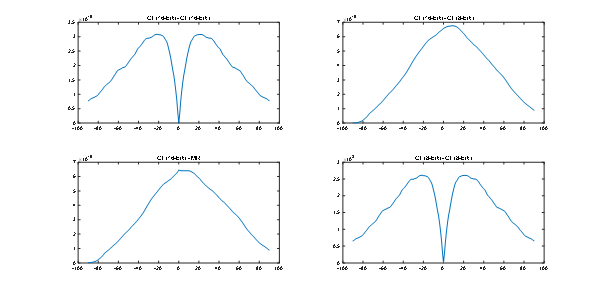
Note that:
- SSD reaches a minimum (of 0) for cases 1 and 4 when the images are in alignment;
- For cases 2 and 3 SSD does not have a minimum when the images are aligned;
- For all cases the SSD drops off as the overlap between the images decreases;
- Although the shape of the SSD curve for cases 1 and 4 is the same, the values of the SSD are different by 2 orders of magnitude.

Make sure you understand why you get these results.


Now modify the `calcSSD` function so that it calculates the Mean Squared Difference and save it as a function called `calcMSD`. Repeat the rotations above and use your calcMSD function to calculate the MSD values for each value of theta. 

In [ ]:
def calcMSD(A,B):
  """
  function to calculate the  mean of squared differences between
  two images
  
  INPUTS:    A: an image stored as a 2D matrix
             B: an image stored as a 2D matrix. B must be the 
                same size as A
                
  OUTPUTS:   MSD: the value of the mean of squared differences
  
  
  NOTE: if either of the images contain NaN values, these 
        pixels should be ignored when calculating the MSD.
  """
  return 

If you plot the results they should appear as in figure 2:
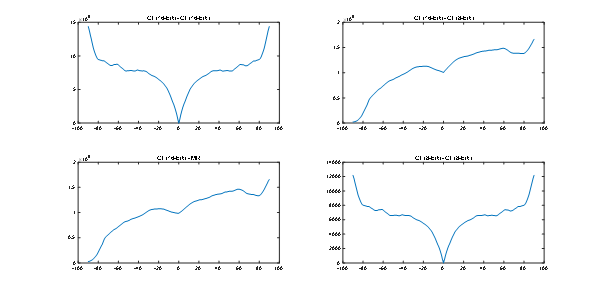

Make sure you understand why:
- The MSD values for cases 1 and 4 are not affected by the amount of overlap between the image;
- The shape of the MSD curves for cases 1 and 4 are the same but the values are different;
- The MSD values for cases 2 and 3 are lower for negative values of theta and higher for positive values.

Look at the `calcEntropies` and `calcNCC` functions within `utils.py` and make sure you understand how they work. Use these functions to calculate the joint and marginal entropies (H_AB, H_A, and H_B), and the Normalised Cross Correlation (NCC) for each value of theta. Calculate the Mutual Information (MI) and Normalised Mutual Information (NMI) from the entropy values, and plot the results NCC, H_AB, MI, and NMI. 
- Do the different measures perform as expected for the different cases? 

Make sure you understand all the results you get.

### PART 2: Demons Registration

Load in the 3 images stored in `cine_MR_1.png`,  `cine_MR_2.png`, and `cine_MR_3.png`, convert them to doubles, and re-orientate them into ‘standard orientation’.

These images contain a 2D sagittal MR slice showing the lung, liver, and surrounding anatomy, at different points in time during free-breathing. Image 1 is at end-exhalation, image 2 at the end-inhalation for a normal breath, and image 3 at end-inhalation for a deep breath. Display the images and observer the motion that occurs between the images. 
- Pay particular attention to motion that you think could be challenging for the demons algorithm to recover, such as very large motion and deformation, or sliding motion that can occur between the lung/liver and surrounding anatomy. 

In [ ]:
## declare target_image and source_image here
from skimage import io
import numpy as np
cine_MR_1 = io.imread('cine_MR_1.png')
target_image = np.flipud(np.double(cine_MR_1)).T

cine_MR_2 = io.imread('cine_MR_2.png')
source_image = np.flipud(np.double(cine_MR_2)).T

You have been provided with a script `demons.py` that will perform a registration based on the demons algorithm using a multi-resolution approach. 
- Try running the algorithm. You first need to import the class defined in `demons.py`; then declare a dictionary of options (default parameters will be used otherwise) to give to the algorithm; then use the run() function to run the algorithm as shown below.

In [ ]:
from demons import DemonsAlgorithm

## declare the option dictionary to supply to the Demons Algorithm
optDict = {}

# set the target and source images
optDict['target'] = target_image 
optDict['source'] = source_image

#the amount of elastic and fluid regularistion to apply. this is the
#standard deviation of the Gaussian used to smooth the update or
#displacement field
#a value of 0 means no smoothing is applied
optDict['sigma_elastic'] = 1
optDict['sigma_fluid'] = 1

#if use_target_grad set to True the target image gradient will be used
#when calculating the demons forces as in the original demons paper. if it
#is set to False the transformed source image gradient will be used
#when calculating the demons forces
optDict['use_target_grad'] = False

# the number of levels to use in the multi-resolution scheme
optDict['num_lev'] = 1

# the maximum number of iterations to use at each level
optDict['max_it'] = 1000

#the threshhold for changes to the deformation field at each iteration. if
#the maximum absolute change in any of the deformation field values is less
#than this threshhold for any iteration the registration will stop running
#in the current level and move to the next level, or finish if this is the
#last level
optDict['df_thresh'] = 0.001

#if check_msd is set to 1 (true) the mean squared difference (MSD) will be
#evaluated at each iteration, and if it has not improved the registration
#will be stopped at this level and proceed to the next levl / finish. if it
#is set to 0 (false) the registration will keep running regardless of
#whether the MSD has improved or not.
optDict['check_MSD'] = True

#the frequency with which update the displayed images. the images will be
#updated every disp_freq iterations
optDict['disp_freq'] = 100

algorithm = DemonsAlgorithm(optDict)
algorithm.run()

You will see multiple figures appear after the cell above. The first figure of 4 show the source and target images at each resolution level along with the transformed source image and the difference image used to inspect the regsitration performance. Yhe next figures show the displacement fields, update fields and transformed image and difference image at each iteration (with the display frequency chosen). 

When the registration finishes compare the result with the target and source images. How well do you think the registration did at aligning the images?

Now have a look through the script. You will see there are several parameters that can be set at the start of the script, and then the code that performs the registration. Make sure you understand what each of the parameters does, how the script works, and how it implements the demons algorithm? Take some time to look through the script. If there are any parts you do not understand ask me or one of the lab assistants to explain it. 

Try changing the values that affect the amount of elastic-like and fluid-like regularisation that applied and rerunning the registration. 

- Does the registration perform differently? 
- Do you understand why the registration performs the way it does for the parameters you chose?

Note – if the registration takes a long time you may want to increase the value of the `disp_freq` parameter. The registration itself should run relatively fast, but updating the displayed images takes some time and slows the progress down. Increasing this parameters means the display is updated less often. Conversely, if registration runs very fast and you miss the details of how the result develop try decreasing this number. 

Now try changing the `use_target_grad` parameter. How does this affect the performance of the registration?
The script can perform a multi-resolution registration, but so far only single-resolution registration have been performed. 

Try resetting the other parameters to their original values (`sigma_elastic` = 1; `sigma_fluid` = 1; `use_target_grad` = 0;) and setting `num_lev` = 3 to use a multi-resolution approach with 3 levels. 

- Do you think using a multi-resolution approach helps? Why?

Try out different combinations of parameters mentioned above, and see if you can get a feel for how they affect the performance and results of the registration, and how they interact with each other.

Also try modifying the other parameters in the script, and understand how they impact the performance of the registration.
Now try swapping the target and source images set at the start of the script. Try using image 3 instead of image 1 or image 2. Can you find parameters that give a good registration result when using images 1 and 3? 